# Inference
This script analyzes a directory of single-cell crops with a ViT model which can be specified.
It keeps track of the metadata produced by the preprocessing pipeline and allows to find which crop produced which embeddings.

## Imports

In [1]:
# Inference
import os
import glob
import tifffile as tiff
import numpy as np
import pandas as pd
import trackpy as tp
import matplotlib.pyplot as plt
from skimage import feature, filters, morphology, transform
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from skimage.feature import peak_local_max, blob_dog, blob_log
from skimage.morphology import white_tophat, black_tophat, disk
from tqdm.notebook import tqdm
from scipy import ndimage


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pyscripts.vision_transformer import VisionTransformer

## Functions

In [2]:
# Functions
def crop_window(img, center_x, center_y, window_size):
    # Convert centroids to integers
    center_x = int(center_x)
    center_y = int(center_y)

    # Crop window
    half_window_size = window_size // 2
    x_from = max(center_x - half_window_size, 0)
    x_to = min(center_x + half_window_size, img.shape[1])
    y_from = max(center_y - half_window_size, 0)
    y_to = min(center_y + half_window_size, img.shape[0])
    window = img[y_from:y_to, x_from:x_to]

    return window


def resize_tensor(img_tensor, size=(128, 128)):
    # img_tensor: (C, H, W)
    img_tensor = img_tensor.unsqueeze(0)  # → (1, C, H, W)
    resized = F.interpolate(img_tensor, size=size, mode='bilinear', align_corners=False, antialias=True)
    return resized.squeeze(0)  # → back to (C, H, W)



class FiveChannelDataset(Dataset):
    def __init__(self, samples, transform=None, window_size=32):
        """
        samples: list of (file_path, centroid)
        """
        self.samples = samples
        self.transform = transform
        self.window_size = window_size

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, centroid = self.samples[idx]

        numeric_metadata = centroid[:4]
        timelapse_id = centroid[4]

        try:
            crop_sequence = tiff.imread(file_path)

            if crop_sequence.ndim != 3 or crop_sequence.shape[2] != 5:
                raise ValueError(f"Invalid shape {crop_sequence.shape}")

            imgs = [crop_sequence[:, :, i] for i in range(crop_sequence.shape[2])]
            x = torch.stack([torch.from_numpy(im.astype(np.float32)) for im in imgs], dim=0)
            # x = resize_tensor(x, size=(224, 224))

            if self.transform:
                x = self.transform(x)

            return x, torch.tensor(numeric_metadata, dtype=torch.float32), file_path, timelapse_id

        except Exception as e:
            print(f"Error reading {file_path}: {e}")

def normalize_channels(x):
    # x: (5,H,W)
    mean = x.mean(dim=[1,2], keepdim=True)
    std  = x.std(dim=[1,2], keepdim=True)
    return (x - mean) / (std + 1e-6)

def collect_crop_paths(
    root_dir: str, 
    metadata_paths: str | list[str] | None = None,
    metadata_glob: str = "metadata_*.csv"
) -> list:
    """
    Collect file paths + metadata only (no image data).
    """
    try:
        metadata_df = pd.read_csv(metadata_path)
        metadata_df['centroid'] = metadata_df.apply(
            lambda row: (row['track_id'], row['t_start'], row['y_center'], row['x_center'], str(row['filename'])), axis=1
        )
        metadata_lookup = metadata_df.set_index('file_path')['centroid']
        print(f"Loaded {len(metadata_lookup)} metadata entries.")
    except Exception as e:
        print(f"Metadata load error: {e}")
        metadata_lookup = pd.Series({}, dtype=object)

    all_tiffs = glob.glob(os.path.join(root_dir, '**', '*.tif'), recursive=True)
    print(f"Found {len(all_tiffs)} TIFFs")

    samples = []
    for file_path in tqdm(all_tiffs):
        abs_path = os.path.realpath(file_path)
        centroid_metadata = metadata_lookup.get(abs_path, (-1, 0, 0, 0, 'Unknown'))
        samples.append((abs_path, centroid_metadata))
    
    return samples


def load_crops_from_directory(
    root_dir: str, 
    metadata_path: str, window_size: int = 32
) -> list:
    """
    Collects and loads all single-cell crop sequences from a single root directory,
    using a separate metadata CSV for accurate centroid lookup.
    """
    # --- 1. Load and Prepare Metadata Lookup ---
    try:
        metadata_df = pd.read_csv(metadata_path)
        # Create the centroid tuple: (track_id, t_start, y_center, x_center)
        metadata_df['centroid'] = metadata_df.apply(
            lambda row: (row['track_id'], row['t_start'], row['y_center'], row['x_center']), 
            axis=1
        )
        # Create a fast O(1) lookup dictionary (Pandas Series indexed by file_path)
        metadata_lookup = metadata_df.set_index('file_path')['centroid']
        print(f"Loaded {len(metadata_lookup)} metadata entries from CSV.")
    except Exception as e:
        print(f"ERROR: Could not load metadata CSV at {metadata_path}. All centroids will be invalid. Error: {e}")
        # Use an empty dict/Series to force fallback
        metadata_lookup = pd.Series({}, dtype=object) 
        
    all_track_windows = []
    
    # --- 2. Collect TIFF files ---
    search_path = os.path.join(root_dir, '**', '*.tif')
    # Note: We use os.path.abspath on the file path later for a reliable key match
    all_tiffs = glob.glob(search_path, recursive=True)
    
    if not all_tiffs:
        print(f"Error: No TIFF crops found recursively in {root_dir}")
        return []

    print(f"Starting crop collection and loading {len(all_tiffs)} files...")

    for file_path in tqdm(all_tiffs, desc="Loading Crops"):
        absolute_path = os.path.realpath(file_path) # Ensure key matches the saved metadata path
        
        # --- 3. Centroid Lookup ---
        centroid_metadata = metadata_lookup.get(absolute_path)
        
        if centroid_metadata is None:
            # Fallback for files not in metadata (e.g., random or mislabeled files)
            centroid_metadata = (-1, 0, 0, 0) # Use dummy values
        
        try:
            # 4. Load the multi-frame TIF file
            crop_sequence = tiff.imread(file_path)
            
            # Check for expected shape (Assuming (H, W, 5) from your cropping code)
            if crop_sequence.ndim != 3 or crop_sequence.shape[2] != 5 or crop_sequence.shape[0] != window_size:
                print(f"  Skipping {os.path.basename(file_path)}: Wrong shape {crop_sequence.shape}")
                continue
            
            # 5. Convert (H, W, 5) to a list of 5 (H, W) images
            windows_per_track = [crop_sequence[:, :, i] for i in range(crop_sequence.shape[2])]
            
            # 6. Append the (data, centroid_metadata, file_path) tuple
            # The 'centroid_metadata' now contains the correct (track_id, t, y, x)
            all_track_windows.append((windows_per_track, centroid_metadata, absolute_path))
            
        except Exception as e:
            print(f"  Error loading {file_path}: {e}")
            
    print(f"\nSuccessfully loaded {len(all_track_windows)} total crops.")
    return all_track_windows

## Config
Run_Name needs to be same as used during preprocessing, alternatively directly set Root_Crop_Directory

In [3]:
# Config
# TODO: improve config
RUN_NAME = 'Exp06_Site37'
EXP_NAME = 'Exp06_Site37'
ROOT_CROP_DIRECTORY = f'/home/nbahou/myimaging/apoDet_refactored/data/{RUN_NAME}/windows_20x_2cat_resize_128' 
WINDOW_SIZE = 128
#IMG_PATH = "/mnt/imaging.data/PertzLab/apoDetection/TIFFs/Exp09_Site05.tif"
#TRACK_DF_PATH = "/home/nbahou/myimaging/apoDet/data/dataset2/track_dfs/Exp09_Site05.csv"

METADATA_FILE_NAME = f'metadata_{EXP_NAME}.csv' 
METADATA_FILE_PATH = os.path.join(ROOT_CROP_DIRECTORY, METADATA_FILE_NAME)

IMG_OUT_PATH = 'inference_data'
os.makedirs(IMG_OUT_PATH, exist_ok=True) 


checkpoint = torch.load('/home/nbahou/myimaging/scDINO/output/test_scDINO_20x_ds2_t5_2cat_128/scDINO_ViTs/300ep_5ch_resize128_25-5-5-1_vitSmall16_lr0003_channel_0_1_2_3_4/checkpoint300.pth', map_location='cpu')



In [4]:
all_track_windows = load_crops_from_directory(
    root_dir=ROOT_CROP_DIRECTORY, 
    metadata_path=METADATA_FILE_PATH,
    window_size=WINDOW_SIZE
)

Loaded 393372 metadata entries from CSV.
Starting crop collection and loading 393372 files...


Loading Crops:   0%|          | 0/393372 [00:00<?, ?it/s]


KeyboardInterrupt



## Dataset & Transformer Set-Up

In [4]:
samples = collect_crop_paths(ROOT_CROP_DIRECTORY, METADATA_FILE_PATH)
dataset = FiveChannelDataset(samples, transform=normalize_channels)

loader = DataLoader(
    dataset,
    batch_size=512,
    shuffle=False,
    num_workers=8,   # Adjust based on CPU
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True,
)

Loaded 390354 metadata entries.
Found 390354 TIFFs


  0%|          | 0/390354 [00:00<?, ?it/s]

In [5]:
# dataset = FiveChannelDataset(all_track_windows, transform=normalize_channels)
# loader  = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=4)


model = VisionTransformer(
    patch_size=16,
    in_chans=5,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4.0,
    qkv_bias=True,
    norm_layer=torch.nn.LayerNorm,
    num_classes=0  # No classification head for self-supervised learning
)


In [6]:
checkpoint = torch.load('/home/nbahou/myimaging/scDINO/output/test_scDINO_20x_ds2_t5_2cat_128/scDINO_ViTs/300ep_5ch_resize128_25-5-5-1_vitSmall16_lr0003_channel_0_1_2_3_4/checkpoint300.pth', map_location='cpu')

# Extract state dict (adjust key name based on your checkpoint)
if 'teacher' in checkpoint:
    state_dict = checkpoint['teacher']  
else:
    state_dict = checkpoint

# Clean keys if needed
clean_dict = {k.replace('module.', '').replace('backbone.', ''): v 
              for k, v in state_dict.items()}

model.load_state_dict(clean_dict, strict=False)
model.eval()



VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(5, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attn): At

## Run Inference

In [7]:
import gc
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch.nn.functional as F
import os # Need this for file handling

# --- CONFIGURATION (unchanged) ---
OUTPUT_FILE = f'{EXP_NAME}_features.jsonl'
CHUNK_SIZE_BATCHES = 200 

# --- INITIALIZATION (unchanged) ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

chunk_embs = []
chunk_centroids = []
chunk_paths = []
chunk_timelapse_ids = []

# Keep track of the file size to see how it grows (optional)
file_size_before_loop = os.path.getsize(OUTPUT_FILE) if os.path.exists(OUTPUT_FILE) else 0

model.eval()
with torch.no_grad():
    for x_batch, cent_batch, path_batch, timelapse_batch in tqdm(loader):
        B = x_batch.shape[0]
        x_batch_gpu = x_batch.to(device)
        
        # 2. Resize on GPU (your correct logic)
        x_batch_resized = F.interpolate(
            x_batch_gpu, 
            size=(224, 224), 
            mode='bilinear', 
            align_corners=False,
            antialias=True
        )
        
        # 3. Inference and Data Collection
        embs = model(x_batch_resized).cpu().numpy()
        
        chunk_embs.extend(embs)
        chunk_centroids.extend(cent_batch.numpy())
        chunk_paths.extend(path_batch)
        chunk_timelapse_ids.extend(timelapse_batch)

        # 4. Save to Disk (Chunking Logic)
        if len(chunk_embs) >= CHUNK_SIZE_BATCHES * loader.batch_size:
            
            # A. Create DataFrame for the current chunk (unchanged logic)
            data_chunk = {
                'track_id': [int(c[0]) for c in chunk_centroids],
                't': [int(c[1]) for c in chunk_centroids],
                'y': [int(c[2]) for c in chunk_centroids],
                'x': [int(c[3]) for c in chunk_centroids],
                'embedding': [e.tolist() for e in chunk_embs],
                'path': chunk_paths,
                'filename': chunk_timelapse_ids 
            }
            df_chunk = pd.DataFrame(data_chunk)
            df_chunk_light = df_chunk[['track_id', 't', 'y', 'x', 'embedding', 'path', 'filename']]
            
            # B. CORRECTED Save to File and Clear RAM
            
            # 1. Serialize the DataFrame chunk to a JSONL string
            json_chunk_str = df_chunk_light.to_json(
                orient='records',
                lines=True
            )
            
            # 2. Use native Python file handling to APPEND the string
            with open(OUTPUT_FILE, 'a') as f:
                f.write(json_chunk_str)
                f.write('\n') # Add a newline to separate chunks cleanly
            
            # C. CRITICAL STEP: CLEAR MEMORY
            chunk_embs = []
            chunk_centroids = []
            chunk_paths = []
            chunk_timelapse_ids = []
            
            del df_chunk, df_chunk_light, data_chunk, json_chunk_str
            gc.collect() 
            
# --- FINAL CHUNK PROCESSING ---
if len(chunk_embs) > 0:
    print(f"Saving final partial chunk of size {len(chunk_embs)}...")
    data_chunk = {
        'track_id': [int(c[0]) for c in chunk_centroids],
        't': [int(c[1]) for c in chunk_centroids],
        'y': [int(c[2]) for c in chunk_centroids],
        'x': [int(c[3]) for c in chunk_centroids],
        'embedding': [e.tolist() for e in chunk_embs],
        'path': chunk_paths,
        'filename': chunk_timelapse_ids
    }
    df_chunk = pd.DataFrame(data_chunk)
    df_chunk_light = df_chunk[['track_id', 't', 'y', 'x', 'embedding', 'path', 'filename']]

    # 1. Serialize the final chunk
    json_chunk_str = df_chunk_light.to_json(
        orient='records',
        lines=True
    )
    
    # 2. Append to file
    with open(OUTPUT_FILE, 'a') as f:
        f.write(json_chunk_str)
        f.write('\n')

    print("Inference completed and all data saved.")

  0%|          | 0/763 [00:00<?, ?it/s]

Saving final partial chunk of size 83154...
Inference completed and all data saved.


## Visualization (UMAP)

In [9]:
import pandas as pd
import numpy as np
import umap
from time import time # Uncomment if you want to use the timer

# --- Configuration ---
# Set the desired number of UMAP dimensions.
INPUT_FILE = f'{EXP_NAME}_features.jsonl'
NUM_UMAP_COMPONENTS = 2
RANDOM_STATE = 42
# ---------------------

# --- 0. Load Data ---
print(f"Loading data from: {INPUT_FILE}...")
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"Error: The input file was not found at {INPUT_FILE}. Check the path.")

# Load the JSONL file (lines=True) into a single DataFrame
df_emb_list = pd.read_json(INPUT_FILE, lines=True)

print(f"Loaded DataFrame Shape: {df_emb_list.shape}")

# --- 1. Prepare Data for UMAP ---
# Crucial step: Convert the list of lists/arrays in the 'embedding' column 
# into a single 2D NumPy array for UMAP.
try:
    X_embeddings = np.array(df_emb_list['embedding'].tolist())
except AttributeError:
    print("Error: 'embedding' column contents cannot be converted to a list of lists. Check data type.")
    raise
    
print(f"UMAP Input Array Shape: {X_embeddings.shape}")
print(f"Using {X_embeddings.shape[1]} features for reduction.")


# --- 2. Apply UMAP Transformation ---
print("\n--- Starting UMAP Transformation ---")
start_time = time()

reducer = umap.UMAP(
    n_components=NUM_UMAP_COMPONENTS,  # Uses the configured number of dimensions
    random_state=RANDOM_STATE,
    n_neighbors=15,
    min_dist=0.1,
    verbose=False # Set to True if you want progress output
)

# Perform the reduction
umap_coordinates = reducer.fit_transform(X_embeddings)

end_time = time()
print(f"UMAP reduction complete in {end_time - start_time:.2f} seconds.")


# --- 3. Add UMAP Coordinates to DataFrame ---
umap_columns = [f'umap_{i+1}' for i in range(NUM_UMAP_COMPONENTS)]

for i, col_name in enumerate(umap_columns):
    df_emb_list[col_name] = umap_coordinates[:, i]

print(f"\nUMAP successfully reduced to {NUM_UMAP_COMPONENTS} dimensions: {umap_columns}")


# --- 4. Display Final Result ---
print("\n--- Final DataFrame Head ---")
display_cols = ['track_id', 't', 'y', 'x'] + umap_columns
print(df_emb_list[display_cols].head(5))

Loading data from: Exp06_Site37_features.jsonl...
Loaded DataFrame Shape: (390354, 7)
UMAP Input Array Shape: (390354, 384)
Using 384 features for reduction.

--- Starting UMAP Transformation ---
UMAP reduction complete in 299.47 seconds.

UMAP successfully reduced to 2 dimensions: ['umap_1', 'umap_2']

--- Final DataFrame Head ---
   track_id    t    y    x     umap_1    umap_2
0       194  232  714  790  12.026996  2.934122
1      2308  115  736  812  11.306785  6.458210
2      2982  204  572   72  12.788400  6.078248
3      1726   69  334  586   9.096071  7.818948
4       447    9  936  294   7.934318  4.821146


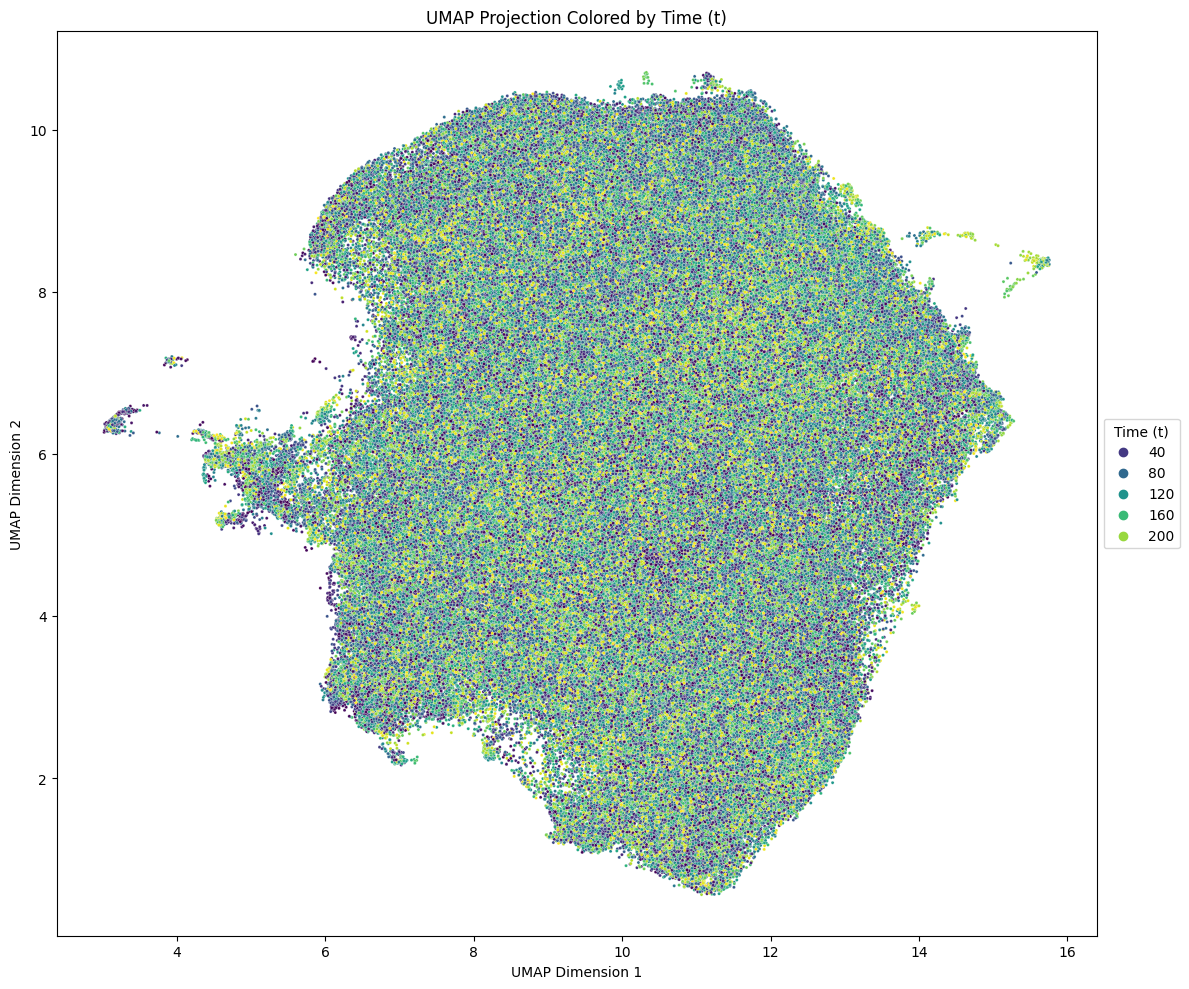

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# We'll use the 't' (time) column to color the points
# Use 'track_id' instead if you want to distinguish individual tracks
sns.scatterplot(
    x='umap_1', 
    y='umap_2', 
    hue='t', 
    data=df_emb_list, 
    s=5, 
    palette='viridis' # A good color map for sequential data like time
)

plt.title('UMAP Projection Colored by Time (t)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Time (t)', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

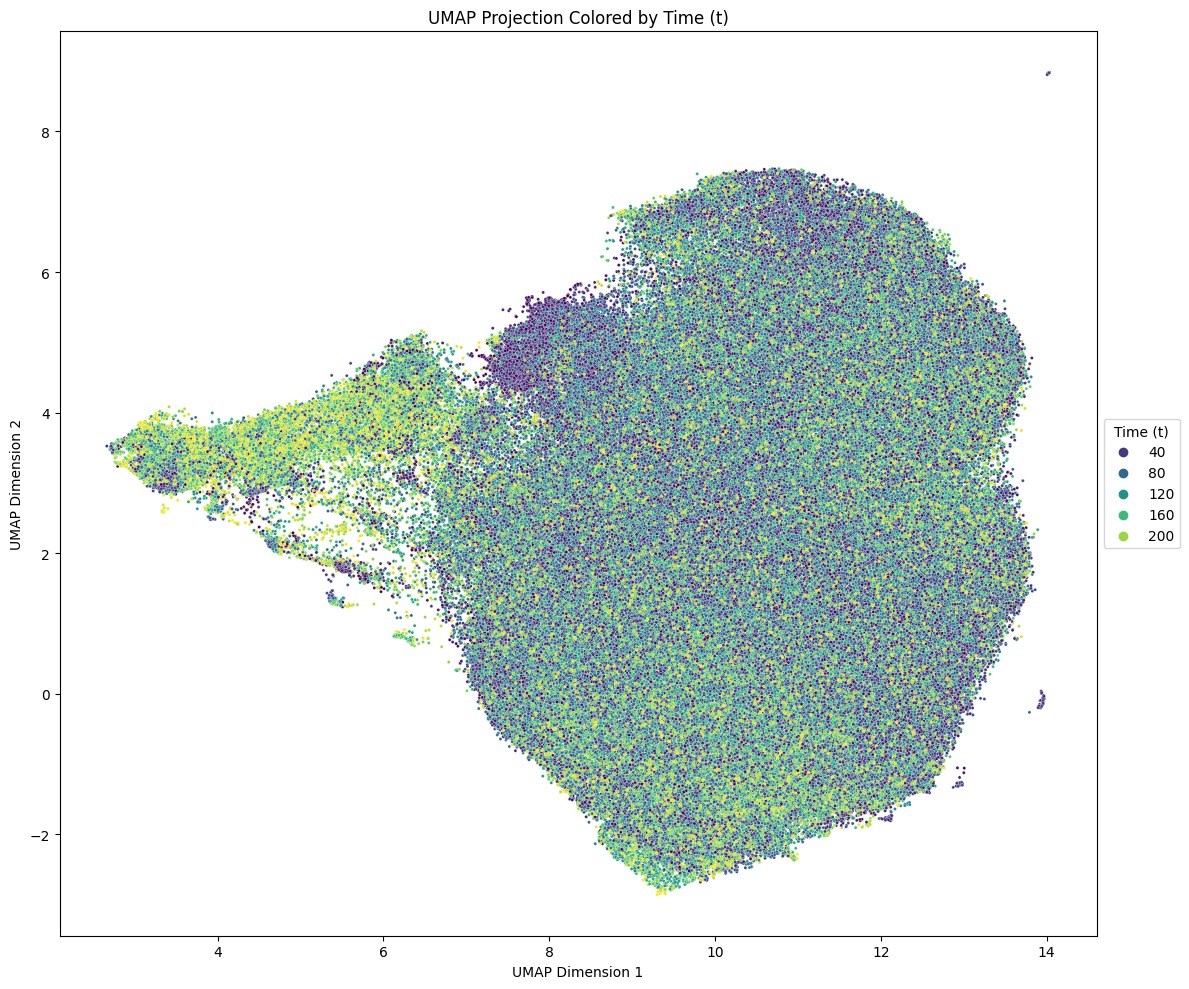

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# We'll use the 't' (time) column to color the points
# Use 'track_id' instead if you want to distinguish individual tracks
sns.scatterplot(
    x='umap_1', 
    y='umap_2', 
    hue='t', 
    data=df_emb_list, 
    s=5, 
    palette='viridis' # A good color map for sequential data like time
)

plt.title('UMAP Projection Colored by Time (t)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Time (t)', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [44]:
# Batch inference with DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

all_embs = []
all_centroids = []
all_paths = []

with torch.no_grad():
    for x_batch, cent_batch, path_batch in tqdm(loader, desc="Running inference", unit="batch", total=len(loader)):
        x_batch = x_batch.to(device)       # (B, 5, 128, 128) - adjusted for your size
        embs = model(x_batch)              # (B, 384) - ViT-Small embedding dim
        all_embs.append(embs.cpu())
        all_centroids.append(cent_batch)
        all_paths.extend(path_batch)
        

# Concatenate all batches
all_embs = torch.cat(all_embs, dim=0).numpy()        # (N, 384)
all_centroids = torch.cat(all_centroids, dim=0).numpy()  # (N, 3)
all_paths = np.array(all_paths).reshape(-1, 1)  # (N, 1)


# Create DataFrame
cols = ['track_id','z', 'y', 'x', 'path'] + [f'emb_{i}' for i in range(all_embs.shape[1])]
df = pd.DataFrame(
    data=np.hstack([all_centroids, all_paths, all_embs]),
    columns=cols
)




print(f"Created DataFrame: {df.shape}")
print(f"Embeddings: {all_embs.shape}, Centroids: {all_centroids.shape}")

Running inference: 100%|████████████████████████████████████████████████████████████████████| 249/249 [01:37<00:00,  2.56batch/s]


Created DataFrame: (127463, 389)
Embeddings: (127463, 384), Centroids: (127463, 4)


In [14]:
import pandas as pd
import numpy as np
import umap 

# --- Configuration ---
# Set the desired number of UMAP dimensions. 
# Changing this value (e.g., to 2 or 3) automatically adjusts the 
# UMAP reduction and the UMAP velocity calculation.
NUM_UMAP_COMPONENTS = 2 
# ---------------------

# --- 1 Calculate SPATIAL Features (time-to-term and velocity in YX space) ---
def calculate_spatial_features(df):
    """Calculates spatial velocity and time-to-termination."""
    
    # Calculate time difference (dt) within each track
    df['dt'] = df.groupby('track_id')['t'].diff().fillna(1.0) # Assumes dt=1 for first point
    df['dy'] = df.groupby('track_id')['y'].diff().fillna(0.0)
    df['dx'] = df.groupby('track_id')['x'].diff().fillna(0.0)

    # Calculate Spatial Velocity (Euclidean distance per time step in YX plane)
    df['spatial_velocity'] = np.sqrt(df['dy']**2 + df['dx']**2) / df['dt']
    df['spatial_velocity'] = df['spatial_velocity'].fillna(0.0) 
    
    # Calculate Time to Termination
    max_t = df.groupby('track_id')['t'].transform('max')
    df['time_to_termination'] = max_t - df['t']
    
    df = df.drop(columns=['dt', 'dy', 'dx'], errors='ignore')
    return df

df_emb_list = calculate_spatial_features(df_emb_list)


# --- 2. Prepare Data for UMAP ---
X_embeddings = np.array(df_emb_list['embedding'].tolist())

print(f"UMAP Input Array Shape: {X_embeddings.shape}")


# --- 3. Apply UMAP Transformation (Generalizing N components) ---
reducer = umap.UMAP(
    n_components=NUM_UMAP_COMPONENTS, # Uses the configured number of dimensions
    random_state=42,      
    n_neighbors=15,       
    min_dist=0.1,
    verbose=True          
)
umap_coordinates = reducer.fit_transform(X_embeddings)


# --- 4. Add UMAP Coordinates to DataFrame (Generalizing N components) ---
umap_columns = []
for i in range(NUM_UMAP_COMPONENTS):
    col_name = f'umap_{i+1}'
    df_emb_list[col_name] = umap_coordinates[:, i]
    umap_columns.append(col_name) # Store names for later use in velocity calculation

print(f"UMAP successfully reduced to {NUM_UMAP_COMPONENTS} dimensions: {umap_columns}")


# --- 4.5 Calculate UMAP Velocity (Generalized for N dimensions) ---

def calculate_umap_velocity(df, umap_dimensions):
    """
    Calculates velocity based on displacement in the N-dimensional UMAP coordinate space.
    
    Args:
        df (pd.DataFrame): DataFrame containing 't' (time) and UMAP columns.
        umap_dimensions (list): List of strings specifying the UMAP column names (e.g., ['umap_1', 'umap_2', ...]).
    """
    
    # Recalculate time difference (dt)
    df['dt'] = df.groupby('track_id')['t'].diff().fillna(1.0)
    
    # Initialize squared displacement sum (d_umap_1^2 + d_umap_2^2 + ... d_umap_n^2)
    df['squared_displacement_sum'] = 0.0
    columns_to_drop = ['dt']
    
    # Loop through each UMAP dimension to calculate displacement and sum the squares
    for col in umap_dimensions:
        # Calculate displacement in the current UMAP dimension
        d_col_name = f'd_{col}'
        df[d_col_name] = df.groupby('track_id')[col].diff().fillna(0.0)
        
        # Add the squared displacement to the running sum
        df['squared_displacement_sum'] += df[d_col_name]**2
        
        # Mark displacement column for later cleanup
        columns_to_drop.append(d_col_name)

    # UMAP Velocity (Magnitude of displacement) = sqrt(squared_displacement_sum) / dt
    df['umap_velocity'] = np.sqrt(df['squared_displacement_sum']) / df['dt']
    df['umap_velocity'] = df['umap_velocity'].fillna(0.0)
    
    # Cleanup temporary columns
    df = df.drop(columns=columns_to_drop + ['squared_displacement_sum'], errors='ignore')
    return df

# Calculate velocity using the dynamically generated UMAP column names
df_emb_list = calculate_umap_velocity(df_emb_list, umap_columns)


# --- 5. Display Final Result ---
print("\n--- Final DataFrame with All Features Added ---")
# Dynamically list the UMAP coordinates in the print statement
display_cols = ['track_id', 't', 'y', 'x', 'spatial_velocity', 'umap_velocity', 'time_to_termination'] + umap_columns
print(df_emb_list[display_cols].head(5))


# --- 6. Save Data for Napari ---
output_filename = "napari_tracks_umap_features.csv"
try:
    # Saving the DataFrame ensures all track metadata and features 
    # are available for napari.
    df_emb_list.to_csv(output_filename, index=False)
    print(f"\n--- Data Saved Successfully ---")
    print(f"File saved to: {output_filename}")
    print(f"The tracks can be visualized in 3D in napari using t, y, x as coordinates, and colored by 'umap_velocity'.")
    print(f"Alternatively, you can visualize the UMAP space in 3D using 'umap_1', 'umap_2', and 'umap_3' as coordinates.")
except Exception as e:
    print(f"Error saving file: {e}")

UMAP Input Array Shape: (1268609, 384)
UMAP(random_state=42, verbose=True)
Thu Oct  9 14:38:20 2025 Construct fuzzy simplicial set
Thu Oct  9 14:38:21 2025 Finding Nearest Neighbors
Thu Oct  9 14:38:21 2025 Building RP forest with 61 trees
Thu Oct  9 14:39:22 2025 NN descent for 20 iterations
	 1  /  20
	 2  /  20
	 3  /  20
	 4  /  20
	 5  /  20
	 6  /  20
	 7  /  20
	Stopping threshold met -- exiting after 7 iterations
Thu Oct  9 14:40:15 2025 Finished Nearest Neighbor Search
Thu Oct  9 14:40:23 2025 Construct embedding


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
# UMAP is already available in your environment as 'umap-learn'
import umap 


# --- 2. Prepare Data for UMAP ---

# UMAP requires the data to be a 2D NumPy array (samples x features).
# We convert the list of embedding lists into a single NumPy array.
X_embeddings = np.array(df_emb_list['embedding'].tolist())

print(f"UMAP Input Array Shape: {X_embeddings.shape}")


# --- 3. Apply UMAP Transformation ---

# Initialize UMAP reducer (reducing to 2 dimensions for visualization/storage)
# Adjust n_neighbors and min_dist for optimal structure preservation.
reducer = umap.UMAP(
    n_components=2,       # Output 2 dimensions (umap_1, umap_2)
    random_state=42,      # Ensures reproducible results
    n_neighbors=15,       # Balance local vs. global structure
    min_dist=0.1          # How tightly points are clustered
)

# Fit and transform the high-dimensional data
umap_coordinates = reducer.fit_transform(X_embeddings)


# --- 4. Add UMAP Coordinates to DataFrame ---

# Add the two resulting columns back to the original DataFrame
df_emb_list['umap_1'] = umap_coordinates[:, 0]
df_emb_list['umap_2'] = umap_coordinates[:, 1]


# --- 5. Display Final Result ---
print("\n--- Final DataFrame with UMAP Coordinates Added ---")
# Show the spatial coordinates and the new UMAP coordinates
print(df_emb_list[['track_id', 'z', 'y', 'x', 'umap_1', 'umap_2']])



In [9]:
### MLP

In [10]:
# Assuming 'embedding' is the column name with the arrays
import joblib
new_features = np.array(df_emb_list['embedding'].tolist())

mlp = joblib.load("classifier_models/mlp/mlp_1.joblib")

# Apply trained classifier
predictions = mlp.predict(new_features)
prediction_probs = mlp.predict_proba(new_features)

# Add results back to your dataframe
df_emb_list['predicted_label'] = predictions
df_emb_list['confidence_no_apo'] = prediction_probs[:, 0]
df_emb_list['confidence_apo'] = prediction_probs[:, 1]
df_emb_list['max_confidence'] = np.max(prediction_probs, axis=1)

print(f"Predictions: {pd.Series(predictions).value_counts()}")

Predictions: 1    1256295
0      12314
dtype: int64
